# Description

This notebooks performs QA checks for a single vendor:
   - Number of NaN data points as % of total
   - Number of data points where `volume=0` as % of total

# Imports

In [1]:
import logging
import os

import core.config.config_ as cconconf
import core.config.config_utils as ccocouti
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hprint as hprint
import helpers.hs3 as hs3
import im_v2.crypto_chassis.data.client as iccdc
import research_amp.cc.qa as ramccqa

/app/helpers/hparquet.py:19: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

INFO: > cmd='/venv/lib/python3.8/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-01a1d7ab-2ff3-43b8-be58-512e183b043c.json'
INFO  # Git
    branch_name='CMTask2329_Run_C1b_for_top30'
    hash='79c27be81'
    # Last commits:
      * 79c27be81 max-rsrch Checkpoint                                                        ( 3 minutes ago) Tue Jul 12 14:44:26 2022  (HEAD -> CMTask2329_Run_C1b_for_top30, origin/CMTask2329_Run_C1b_for_top30)
      * d5fecbbae Sonya Nikiforova Cm task2318 pytest repro issue 20220710 (#2323)                   (85 minutes ago) Tue Jul 12 13:22:32 2022  (origin/master, origin/HEAD, master)
      * bb55ffcb3 Daniil Tikhomirov Cm task2302 add large binance futures (#2328)                     (   3 hours ago) Tue Jul 12 11:49:27 2022           
# Machine info
    system=Linux
    node name=0985224409db
    release=5.13.0-1022-aws
    version=#24~20.04.1-Ubuntu SMP Thu Apr 7 22:10:15 UTC 2022
    machine=x86_64
    processor=x86_64
    

# Configs

In [3]:
def get_cmtask2329_config() -> cconconf.Config:
    """
    Get task2329-specific config.
    """
    config = cconconf.Config()
    param_dict = {
        "data": {
            # Parameters for client initialization.
            "im_client": {
                "universe_version": "v4",
                "resample_1min": False,
                "root_dir": os.path.join(
                    hs3.get_s3_bucket_path("ck"), "reorg", "historical.manual.pq"
                ),
                "partition_mode": "by_year_month",
                "dataset": "ohlcv",
                "contract_type": "futures",
                "data_snapshot": "20220707",
                "aws_profile": "ck",
            },
            # Parameters for data query.
            "read_data": {
                "start_ts": None,
                "end_ts": None,
                "columns": ["full_symbol", "close", "volume"],
                "filter_data_mode": "assert",
            },
        },
        "column_names": {
            "full_symbol": "full_symbol",
            "close_price": "close",
        },
        "stats": {
            "threshold": 30,
        },
    }
    config = cconfig.Config.from_dict(param_dict)
    return config


config = get_cmtask2329_config()
print(config)

data:
  im_client:
    universe_version: v4
    resample_1min: False
    root_dir: s3://cryptokaizen-data/reorg/historical.manual.pq
    partition_mode: by_year_month
    dataset: ohlcv
    contract_type: futures
    data_snapshot: 20220707
    aws_profile: ck
  read_data:
    start_ts: None
    end_ts: None
    columns: ['full_symbol', 'close', 'volume']
    filter_data_mode: assert
column_names:
  full_symbol: full_symbol
  close_price: close
stats:
  threshold: 30


# Load the data

In [4]:
client = iccdc.CryptoChassisHistoricalPqByTileClient(
    **config["data"]["im_client"]
)

In [5]:
universe = client.get_universe()
universe

['binance::ADA_USDT',
 'binance::BNB_USDT',
 'binance::BTC_USD',
 'binance::BTC_USDT',
 'binance::DOGE_USDT',
 'binance::DOT_USDT',
 'binance::EOS_USDT',
 'binance::ETH_USD',
 'binance::ETH_USDT',
 'binance::SOL_USDT',
 'binance::XRP_USDT']

In [6]:
data = client.read_data(universe, **config["data"]["read_data"])
data.head(3)

,full_symbol,close,volume
timestamp,,,
2021-08-07 00:00:00+00:00,binance::ADA_USDT,1.4018,236179.00
2021-08-07 00:00:00+00:00,binance::BNB_USDT,341.9400,1240.18
2021-08-07 00:00:00+00:00,binance::BTC_USD,42829.0000,104034.00


# QA checks

Major metric for a QA check is `"bad data [%]"` which is the sum of `"volume=0 [%]"` and `"NaNs [%]"`.

In [7]:
vendor_name = "CryptoChassis"
binance_timestamp_stats = ramccqa.get_timestamp_stats(data, vendor_name)
binance_timestamp_stats

,min_timestamp,max_timestamp,days_available
binance::ADA_USDT,2021-08-07 00:00:00+00:00,2022-07-06 23:59:00+00:00,333
binance::BNB_USDT,2021-08-07 00:00:00+00:00,2022-07-06 23:59:00+00:00,333
binance::BTC_USD,2021-08-07 00:00:00+00:00,2022-07-06 23:59:00+00:00,333
binance::BTC_USDT,2021-08-07 00:00:00+00:00,2022-07-06 23:59:00+00:00,333
binance::DOGE_USDT,2021-08-07 00:00:00+00:00,2022-07-06 23:59:00+00:00,333
binance::DOT_USDT,2021-08-07 00:00:00+00:00,2022-07-06 23:59:00+00:00,333
binance::EOS_USDT,2021-08-07 00:00:00+00:00,2022-07-06 23:59:00+00:00,333
binance::ETH_USD,2021-08-07 00:00:00+00:00,2022-07-06 23:59:00+00:00,333
binance::ETH_USDT,2021-08-07 00:00:00+00:00,2022-07-06 23:59:00+00:00,333
binance::SOL_USDT,2021-10-13 17:49:00+00:00,2022-07-06 23:59:00+00:00,266


In [8]:
agg_level_full_symbol = ["full_symbol"]
binance_bad_data_stats = ramccqa.get_bad_data_stats(
    data, agg_level_full_symbol, vendor_name
)
binance_bad_data_stats

,bad data [%],missing bars [%],volume=0 [%],NaNs [%]
binance::ADA_USDT,0.230165,0.230165,0.0,0.0
binance::BNB_USDT,0.055098,0.055098,0.0,0.0
binance::BTC_USD,0.058425,0.058425,0.0,0.0
binance::BTC_USDT,0.045534,0.045534,0.0,0.0
binance::DOGE_USDT,0.053019,0.053019,0.0,0.0
binance::DOT_USDT,0.073187,0.073187,0.0,0.0
binance::EOS_USDT,0.048029,0.048029,0.0,0.0
binance::ETH_USD,0.063207,0.063207,0.0,0.0
binance::ETH_USDT,0.050524,0.050524,0.0,0.0
binance::SOL_USDT,0.241777,0.241777,0.0,0.0


In [9]:
agg_level_full_symbol_year_month = ["full_symbol", "year", "month"]
bad_data_stats_by_year_month = ramccqa.get_bad_data_stats(
    data, agg_level_full_symbol_year_month, vendor_name
)
bad_data_stats_by_year_month

bad data [%]  missing bars [%]  volume=0 [%]  NaNs [%]
binance::ADA_USDT  2021 8       0.008333          0.008333           0.0       0.0
                        9       0.118056          0.118056           0.0       0.0
                        10      0.483871          0.483871           0.0       0.0
                        11      0.025463          0.025463           0.0       0.0
                        12      0.000000          0.000000           0.0       0.0
                   2022 1       0.000000          0.000000           0.0       0.0
                        2       0.000000          0.000000           0.0       0.0
                        3       0.000000          0.000000           0.0       0.0
                        4       1.703704          1.703704           0.0       0.0
                        5       0.201613          0.201613           0.0       0.0
                        6       0.000000          0.000000           0.0       0.0
                        7       0.000000          0.000000           0.0       0.0
binance::BNB_USDT  2021 8       0.008333          0.008333           0.0       0.0
                        9       0.120370          0.120370           0.0       0.0
                        10      0.259857          0.259857           0.0       0.0
                        11      0.002315          0.002315           0.0       0.0
                        12      0.000000          0.000000           0.0       0.0
                   2022 1       0.000000          0.000000           0.0       0.0
                        2       0.000000          0.000000           0.0       0.0
                        3       0.064964          0.064964           0.0       0.0
                        4       0.000000          0.000000           0.0       0.0
                        5       0.143369          0.143369           0.0       0.0
                        6       0.000000          0.000000           0.0       0.0
                        7       0.000000          0.000000           0.0       0.0
binance::BTC_USD   2021 8       0.008333          0.008333           0.0       0.0
                        9       0.157407          0.157407           0.0       0.0
                        10      0.194892          0.194892           0.0       0.0
                        11      0.002315          0.002315           0.0       0.0
                        12      0.000000          0.000000           0.0       0.0
                   2022 1       0.000000          0.000000           0.0       0.0
                        2       0.000000          0.000000           0.0       0.0
                        3       0.004480          0.004480           0.0       0.0
                        4       0.064815          0.064815           0.0       0.0
                        5       0.022401          0.022401           0.0       0.0
                        6       0.185185          0.185185           0.0       0.0
                        7       0.023148          0.023148           0.0       0.0
binance::BTC_USDT  2021 8       0.008333          0.008333           0.0       0.0
                        9       0.148148          0.148148           0.0       0.0
                        10      0.194892          0.194892           0.0       0.0
                        11      0.002315          0.002315           0.0       0.0
                        12      0.000000          0.000000           0.0       0.0
                   2022 1       0.000000          0.000000           0.0       0.0
                        2       0.000000          0.000000           0.0       0.0
                        3       0.000000          0.000000           0.0       0.0
                        4       0.000000          0.000000           0.0       0.0
                        5       0.143369          0.143369           0.0       0.0
                        6       0.000000          0.000000           0.0       0.0
                        7       0.000000    

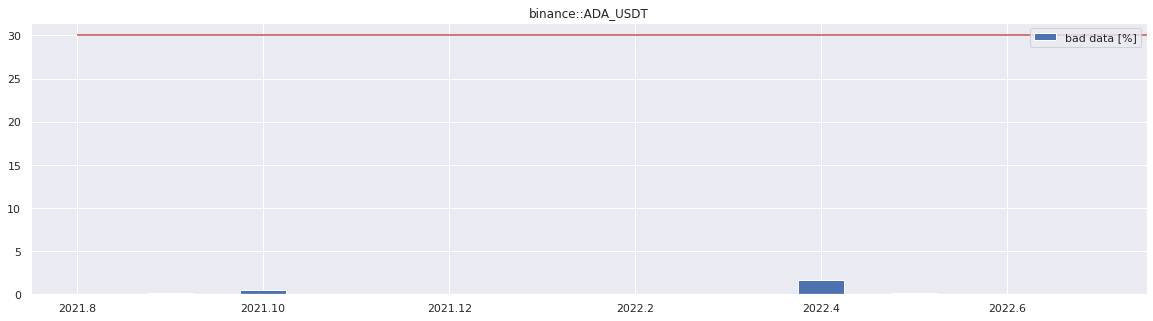

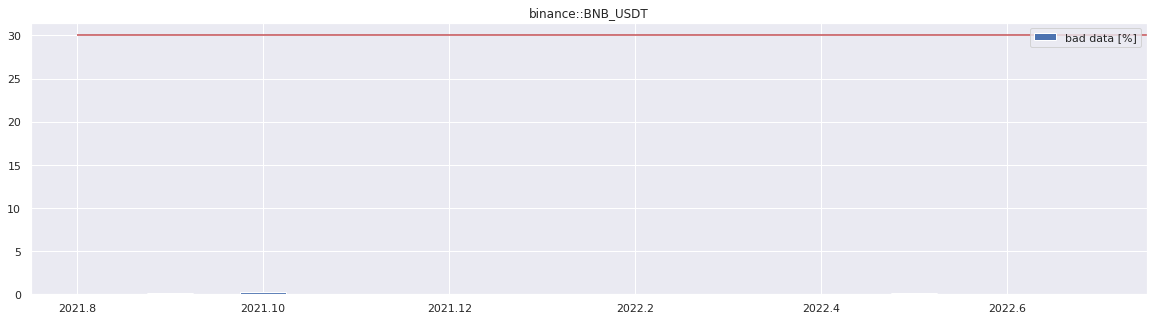

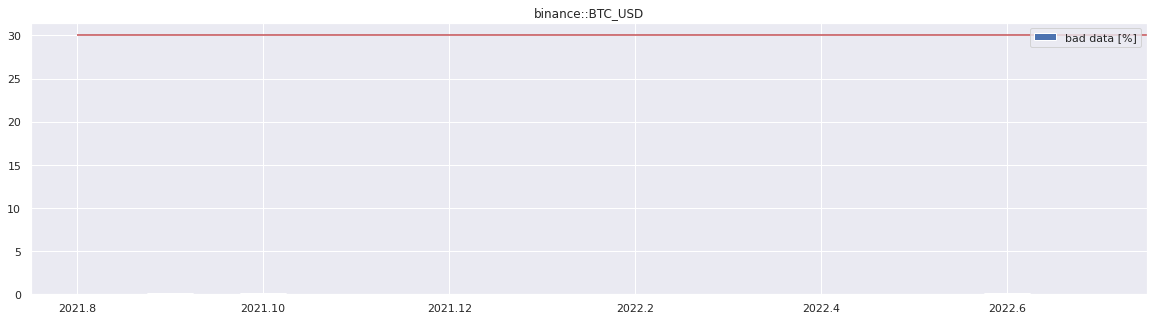

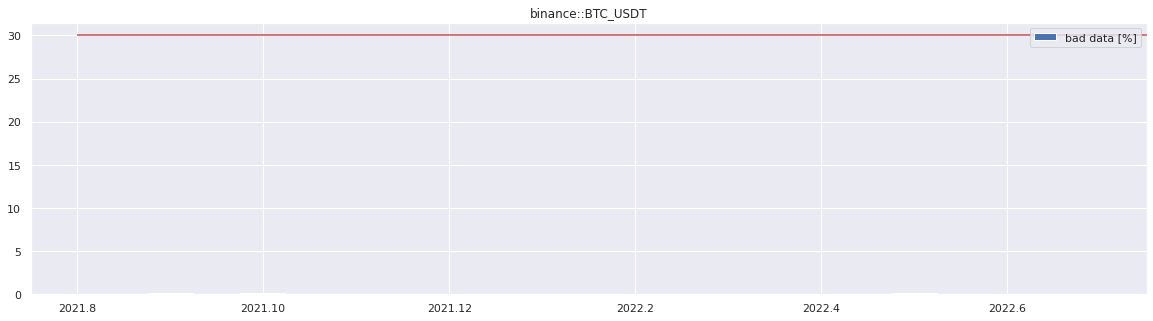

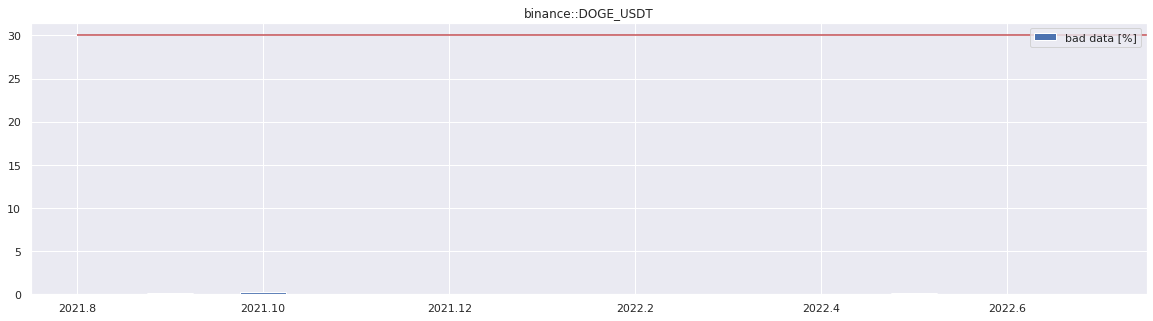

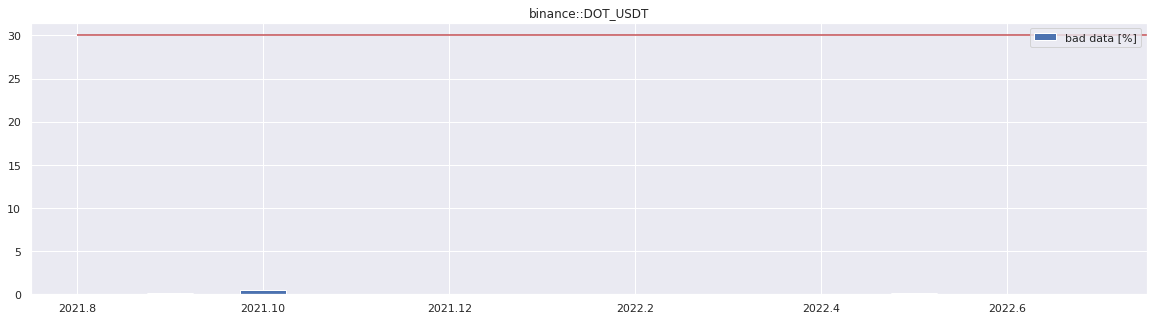

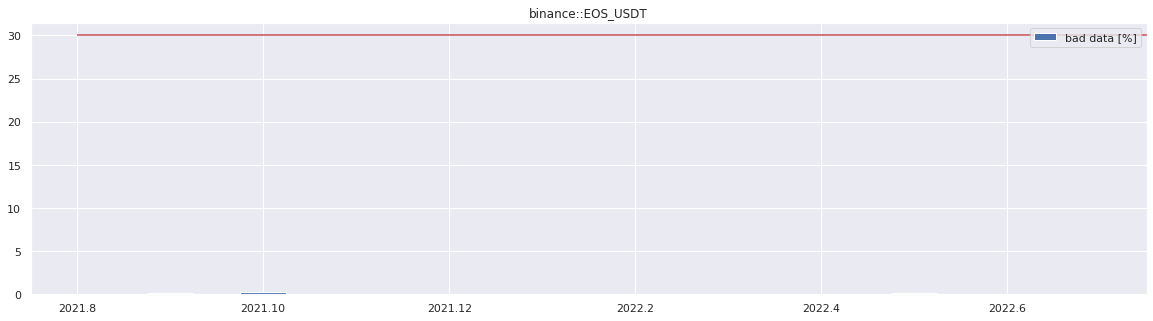

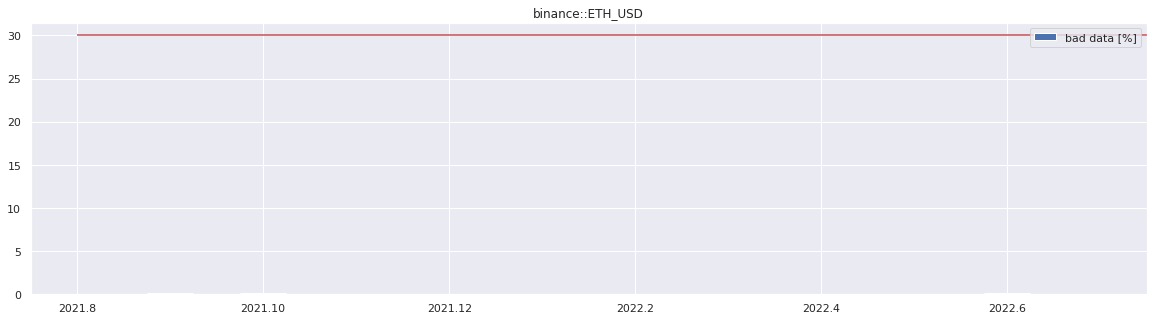

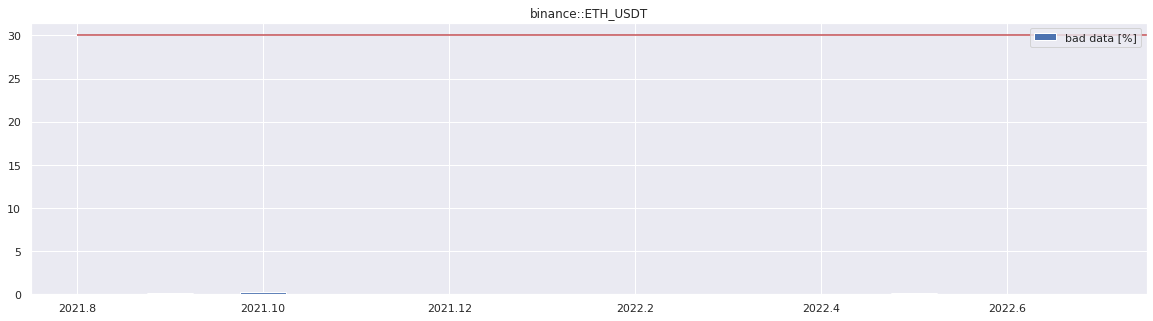

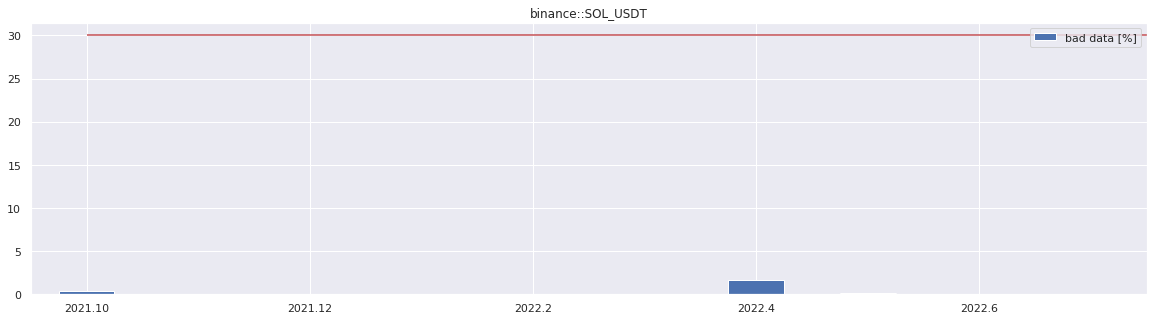

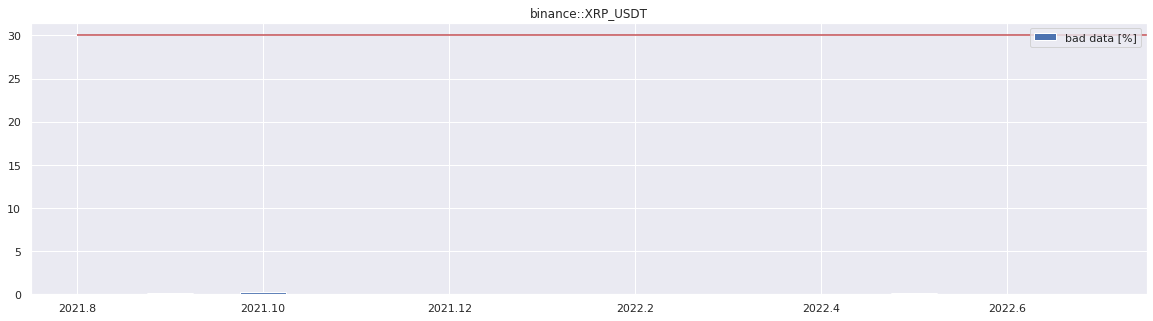

In [10]:
_ = ramccqa.plot_bad_data_by_year_month_stats(
    bad_data_stats_by_year_month, config["stats"]["threshold"]
)